In [2]:
import matplotlib.pyplot as plt
import numpy as np
from dataset import *
from models import *
import torch
import math

Loaded trained_models/ResAttUnet_csize64_max_\best_iou_8_0.7762.pt at epoch 8


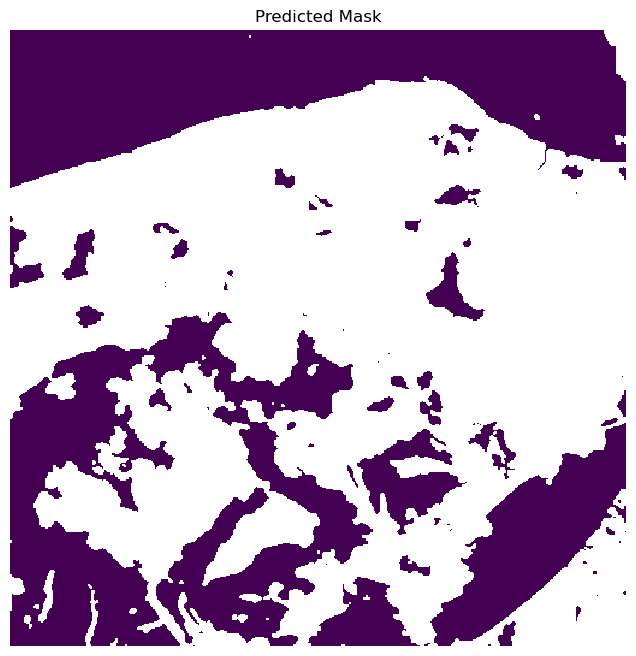

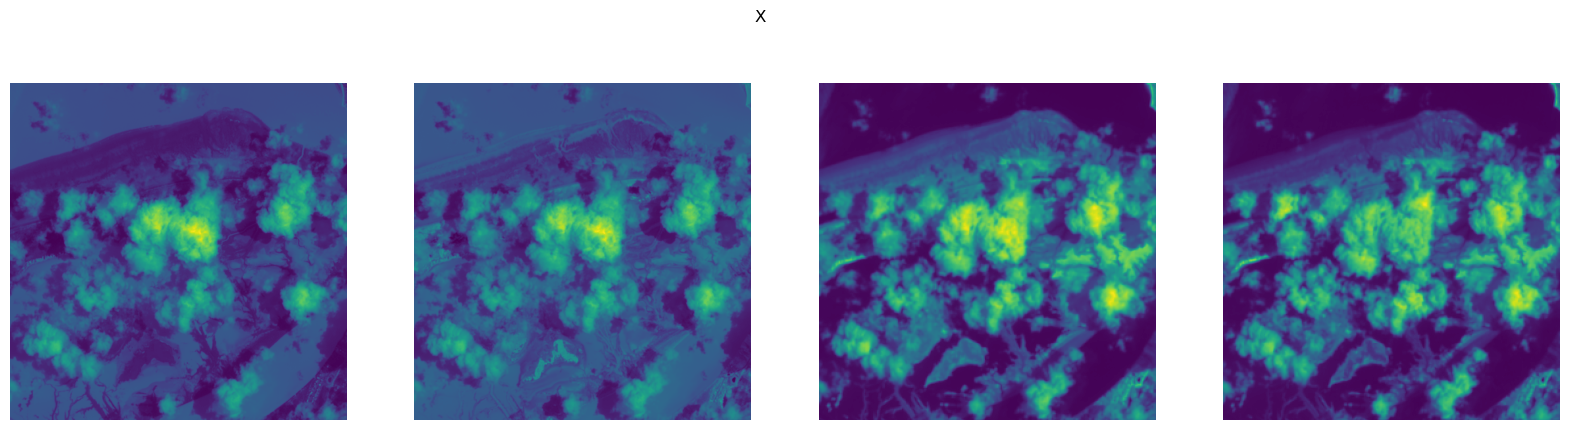

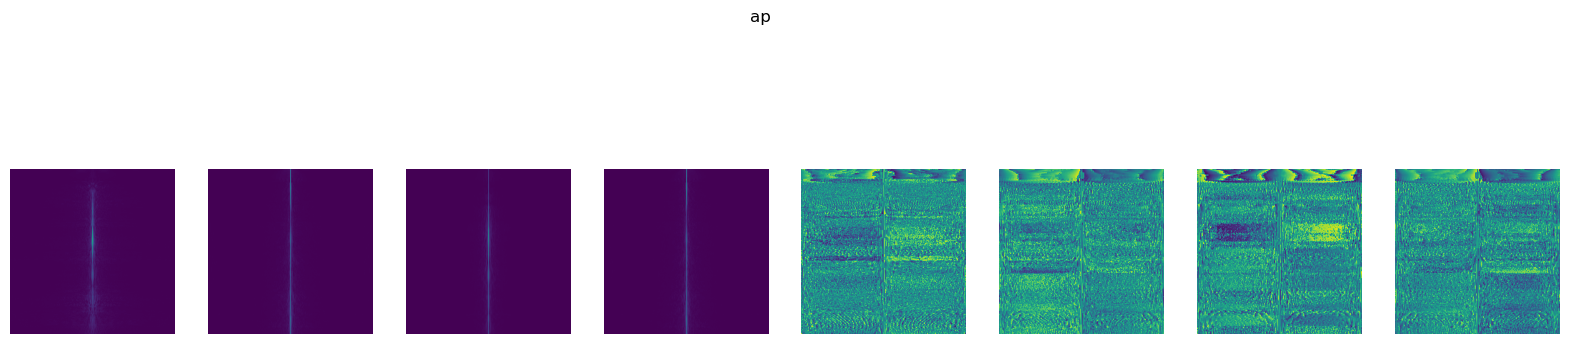

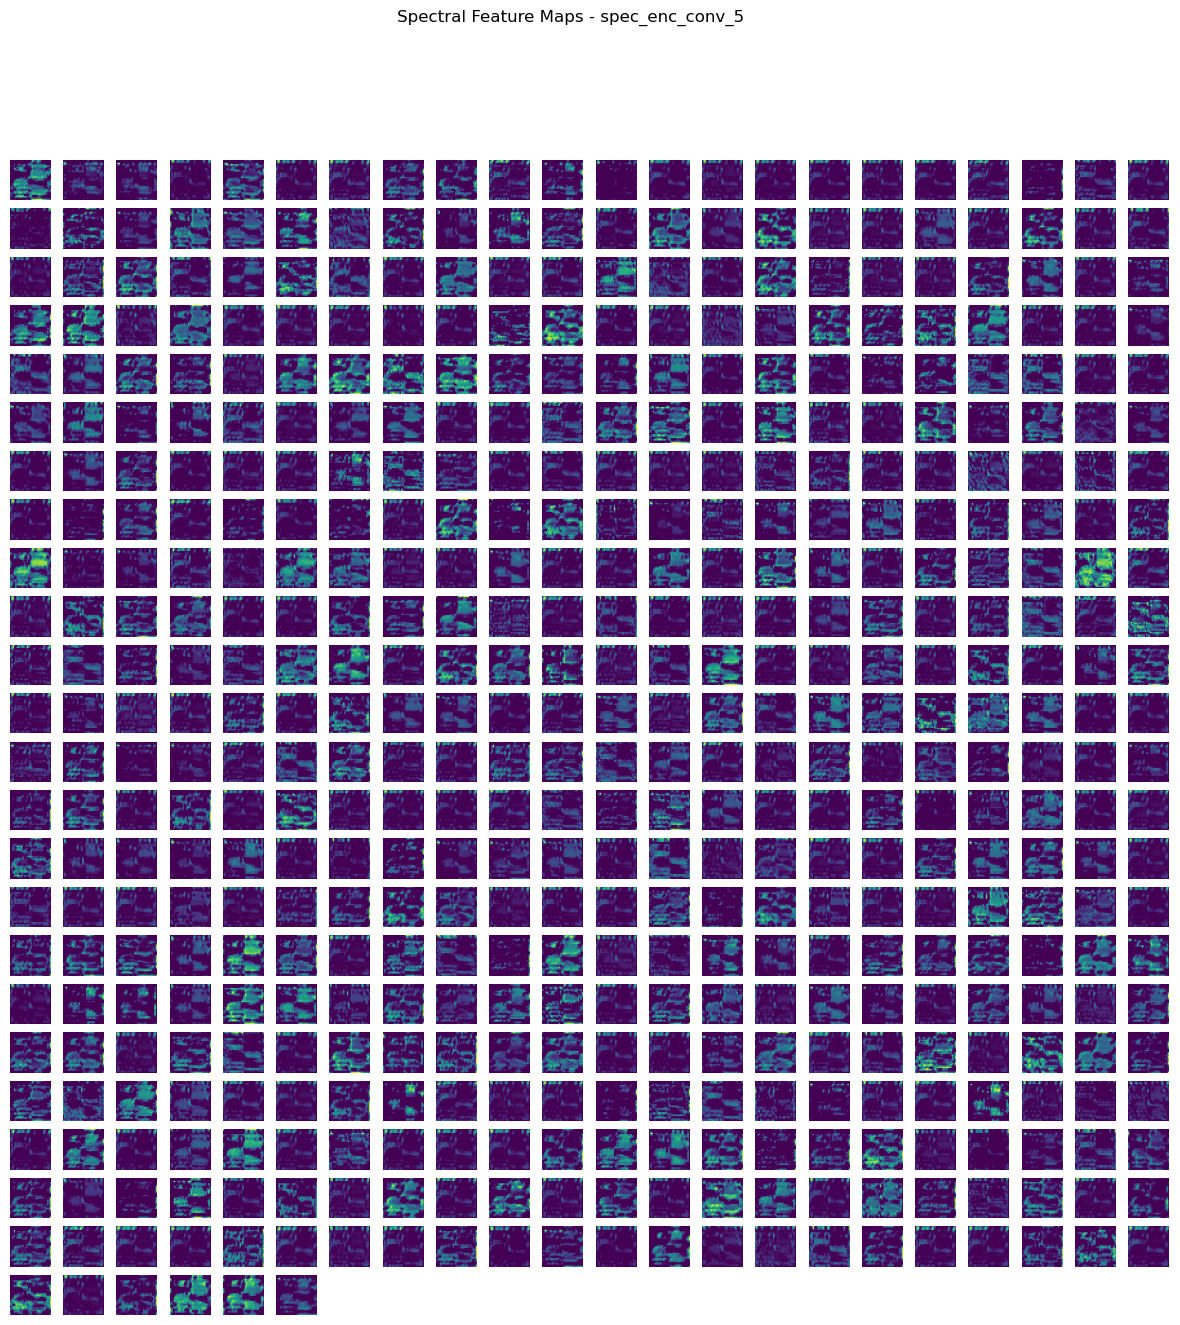

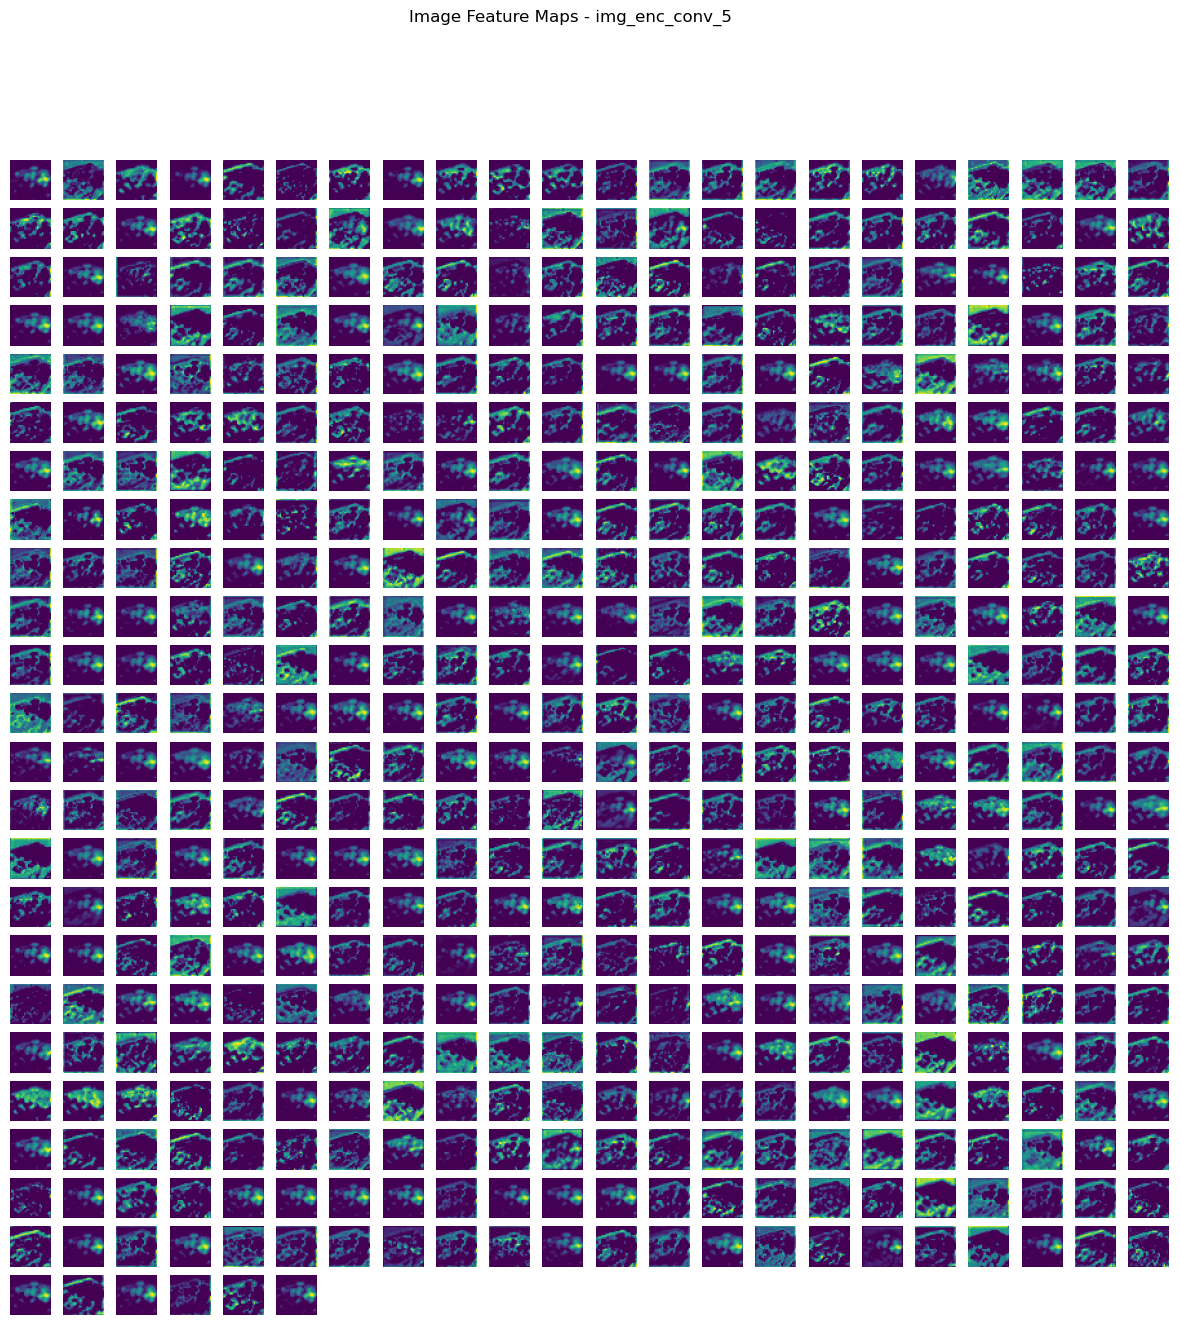

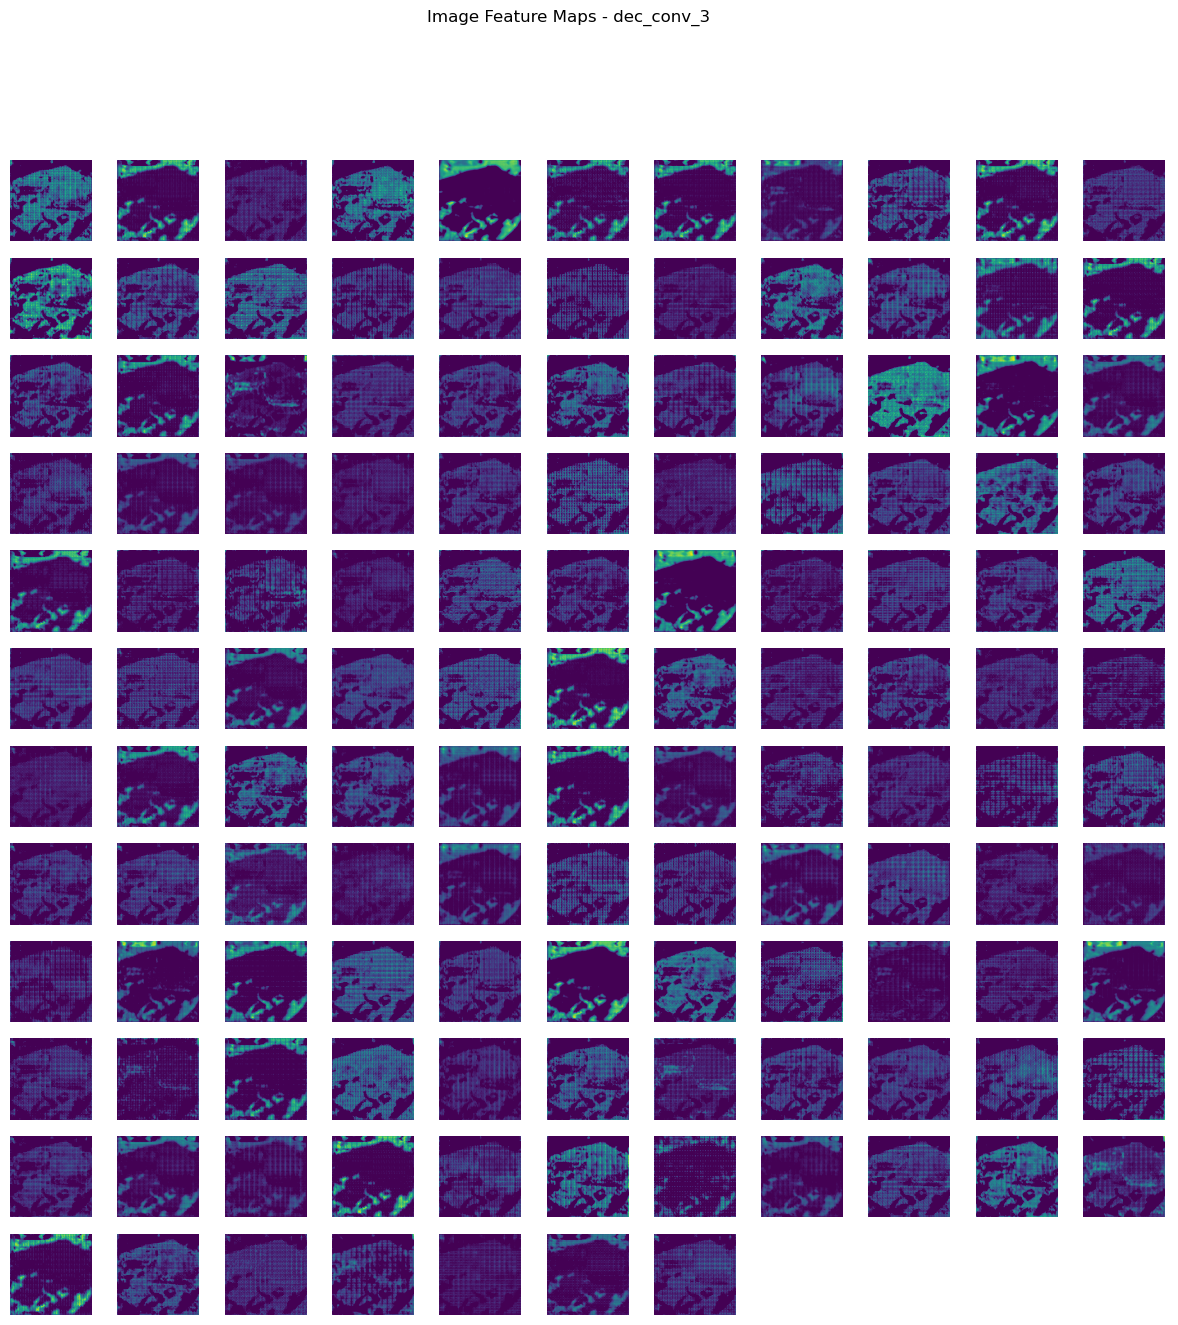

In [40]:
model_weights_path = glob.glob(f"trained_models/ResAttUnet_csize64_max_/best_iou*")[0]
model =  ResAttUnet(4, 8, 2)
model = model.cuda()
model.eval()

cp = torch.load(model_weights_path)
model.load_state_dict(cp["model_state_dict"])
print(f"Loaded {model_weights_path} at epoch {cp['epoch_num']}")

# Loading data from precomputed dataset
path = "C:/Users/The Son/Desktop/Uni/Berlin/Masterarbeit/Data/model_data/test"
data = np.load(f"{path}/10.npz", allow_pickle=True)
data = data["arr_0"][0]
X = data["image"]
X = torch.tensor(np.expand_dims(X, axis=0))

amps = data["amplitude"]
phases = data["phase"]
X = X.cuda(non_blocking=True).float()
ap = torch.tensor(np.expand_dims(np.concatenate([amps, phases], axis=0), axis=0)).cuda(non_blocking=True).float()

output, spec_feature_map, img_feature_map, dec_conv_3 = model(X, ap)

preds = torch.softmax(model(X, ap)[0], dim=1)[:, 1]
preds = (preds > 0.5) * 1
preds = preds.cpu().numpy()
pred = np.ma.masked_where(preds == 0, preds)

plt.figure(figsize=(8, 8))
plt.imshow(pred[0], cmap='viridis')
plt.title("Predicted Mask")
plt.axis('off')
plt.show()

def visualize_feature_maps(feature_map, title="Feature Maps"):
    num_channels = feature_map.shape[1]
    
    # Determine the grid size (rows x cols)
    num_cols = int(math.sqrt(num_channels))
    num_rows = math.ceil(num_channels / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axes = axes.flatten()

    for i in range(num_channels):
        axes[i].imshow(feature_map[0, i].detach().cpu().numpy(), cmap='viridis')
        axes[i].axis('off')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(title)
    plt.show()

def visualize(data, title):
    num_channels = data.shape[1]
    fig, axes = plt.subplots(1, num_channels, figsize=(20, 5))
    for i in range(num_channels):
        axes[i].imshow(data[0, i].detach().cpu().numpy(), cmap='viridis')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

visualize(X, "X")
visualize(ap, "ap")
visualize_feature_maps(spec_feature_map, title="Spectral Feature Maps - spec_enc_conv_5")
visualize_feature_maps(img_feature_map, title="Image Feature Maps - img_enc_conv_5")
visualize_feature_maps(dec_conv_3, title="Image Feature Maps - dec_conv_3")